# Predicting Heart Disease - A Classification Problem for Cleveland Patients

##### Group 19: Matthew Campbell, Andy Li, Fang Peian, Pedro Vieira Sodre

### A) Introduction:

All over the world, developed nations provide a comfortable and safe quality of life. However, this has led their populations to trend towards more sedentary, high caloric lifestyles that have been proven to play a major role in the increased incidence of heart disease (Ornish et al., 1990). Heart disease is one of the leading causes of mortality in the Western world, and therefore, factors that might contribute to its diagnosis are under constant study.

In this project, our team will analyze various factors that are believed to play some role in the development of heart disease. We will use a heart disease data set from the [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/datasets/Heart+Disease) to accomplish this. We will be analyzing the processed data from Cleveland consisting of 14 different variables collected from patients entering the hospital and complaining of their chest pain. We will tidy this dataset and determine the optimal number of predictor variables for a K-nearest neighbors (KNN) classification that will answer the following question:
    
    In Cleveland, are there predictors that nicely segregate patients with heart disease from patients without heart disease. And, can we use these factors to accurately predict whether or not new patients are likely to have advanced heart disease?  
***
   

### B) Preliminary Exploratory Data Analysis:

For this project we will load the following three library packages:
* tidyverse - to collect, tidy and wrangle our dataset
* repr - for plotting our visualizations
* tidymodels - to streamline our KNN calculations
* cowplot - to aid in visualizations

In [20]:
library(tidyverse)
library(repr)
library(tidymodels)
library(cowplot)

Next, we will download our dataset from the web and rename all of the variable columns with the names given in the original website. We have included a list describing all the predictors in an appendix at the end of this proposal. The data set contains 303 observations.

In [21]:
cleveland_heart_data <- read_csv(file = "https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.cleveland.data", 
                                 col_names = FALSE) %>%
                        rename(age = "X1",
                                sex = "X2",
                                chest_pain_type = "X3",
                                resting_bp = "X4",
                                cholesterol = "X5",
                                fasting_bs = "X6",
                                resting_ecg = "X7",
                                heartrate_max = "X8",
                                exang = "X9",
                                oldpeak = "X10",
                                slope = "X11",
                                ca = "X12",
                                thal = "X13",
                                disease_status = "X14")

head(cleveland_heart_data)
nrow(cleveland_heart_data)

Parsed with column specification:
cols(
  X1 = col_double(),
  X2 = col_double(),
  X3 = col_double(),
  X4 = col_double(),
  X5 = col_double(),
  X6 = col_double(),
  X7 = col_double(),
  X8 = col_double(),
  X9 = col_double(),
  X10 = col_double(),
  X11 = col_double(),
  X12 = col_character(),
  X13 = col_character(),
  X14 = col_double()
)



age,sex,chest_pain_type,resting_bp,cholesterol,fasting_bs,resting_ecg,heartrate_max,exang,oldpeak,slope,ca,thal,disease_status
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<dbl>
63,1,1,145,233,1,2,150,0,2.3,3,0.0,6.0,0
67,1,4,160,286,0,2,108,1,1.5,2,3.0,3.0,2
67,1,4,120,229,0,2,129,1,2.6,2,2.0,7.0,1
37,1,3,130,250,0,0,187,0,3.5,3,0.0,3.0,0
41,0,2,130,204,0,2,172,0,1.4,1,0.0,3.0,0
56,1,2,120,236,0,0,178,0,0.8,1,0.0,3.0,0


[1] 303

Upon examination of the original data set in a text editor, we discovered that there are missing measurements represented by question marks (?), and that there are 6 total. We will filter for (?) to make sure this is true for our loaded data.

In [22]:
question_check <- cleveland_heart_data %>%
    filter(age == "?" |
           sex == "?" |
           chest_pain_type == "?" |
           resting_bp == "?" |
           cholesterol == "?" |
           fasting_bs == "?" |
           resting_ecg == "?" |
           heartrate_max == "?" |
           exang == "?" |
           oldpeak == "?" |
           slope == "?" |
           ca == "?" |
           thal == "?")
question_check

age,sex,chest_pain_type,resting_bp,cholesterol,fasting_bs,resting_ecg,heartrate_max,exang,oldpeak,slope,ca,thal,disease_status
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<dbl>
53,0,3,128,216,0,2,115,0,0.0,1,0.0,?,0
52,1,3,138,223,0,0,169,0,0.0,1,?,3.0,0
43,1,4,132,247,1,2,143,1,0.1,2,?,7.0,1
52,1,4,128,204,1,0,156,1,1.0,2,0.0,?,2
58,1,2,125,220,0,0,144,0,0.4,2,?,7.0,0
38,1,3,138,175,0,0,173,0,0.0,1,?,3.0,0


We can see that there are indeed 6 total missing measurements located in the ca and thal columns. We will proceed after removing these observations so they don't have an impact on any future analysis we perform.

In [23]:
no_miss_heart_data <- cleveland_heart_data %>%
    filter(thal != "?", ca != "?")

head(no_miss_heart_data)
nrow(no_miss_heart_data)

age,sex,chest_pain_type,resting_bp,cholesterol,fasting_bs,resting_ecg,heartrate_max,exang,oldpeak,slope,ca,thal,disease_status
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<dbl>
63,1,1,145,233,1,2,150,0,2.3,3,0.0,6.0,0
67,1,4,160,286,0,2,108,1,1.5,2,3.0,3.0,2
67,1,4,120,229,0,2,129,1,2.6,2,2.0,7.0,1
37,1,3,130,250,0,0,187,0,3.5,3,0.0,3.0,0
41,0,2,130,204,0,2,172,0,1.4,1,0.0,3.0,0
56,1,2,120,236,0,0,178,0,0.8,1,0.0,3.0,0


[1] 297

We have successfully downloaded our dataset and removed the 6 missing values, bringing our total data set down to 297 observations. Now we must tidy it so it is easier to use.  

Firstly, we need to make sure every variable has the correct data type. For example, we can see that some clearly numerical variables have erroneously been assigned the character data type. The appendix has information on the variables that will tell us what data type each variable should be. In addition, the following variables SHOULD be changed to factor data type, but we will need to change them to integers to include them as possible predictors in our future KNN classification analysis:
1) sex  
2) chest_pain_type  
3) fasting_bs  
4) resting_ecg  
5) exang  
6) slope  
7) ca  
8) thal  

In [24]:
labelled_heart_data <- no_miss_heart_data %>%
    mutate(age = as.integer(age),
           sex = as.integer(sex),
           chest_pain_type = as.integer(chest_pain_type),
           resting_bp = as.integer(resting_bp),
           cholesterol = as.integer(cholesterol),
           fasting_bs = as.integer(fasting_bs),
           resting_ecg = as.integer(resting_ecg),
           heartrate_max = as.integer(heartrate_max),
           exang = as.integer(exang),
           slope = as.integer(slope),
           ca = as.integer(ca),
           thal = as.integer(thal))

head(labelled_heart_data)

age,sex,chest_pain_type,resting_bp,cholesterol,fasting_bs,resting_ecg,heartrate_max,exang,oldpeak,slope,ca,thal,disease_status
<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<dbl>,<int>,<int>,<int>,<dbl>
63,1,1,145,233,1,2,150,0,2.3,3,0,6,0
67,1,4,160,286,0,2,108,1,1.5,2,3,3,2
67,1,4,120,229,0,2,129,1,2.6,2,2,7,1
37,1,3,130,250,0,0,187,0,3.5,3,0,3,0
41,0,2,130,204,0,2,172,0,1.4,1,0,3,0
56,1,2,120,236,0,0,178,0,0.8,1,0,3,0


Now all our variables are the correct data type, with the exception of disease status. This variable is a little strange. In the file notes it states that 0 means the patient has no disease, and anything greater than 0 means the patient has heart disease. Therefore, we need to reclassify this variable so:
* 0 = no heart disease
* 1 =< heart disease is present

In [25]:
labelled_heart_data["disease_status"][labelled_heart_data["disease_status"] == 1] <- 5
labelled_heart_data["disease_status"][labelled_heart_data["disease_status"] == 2] <- 5
labelled_heart_data["disease_status"][labelled_heart_data["disease_status"] == 3] <- 5
labelled_heart_data["disease_status"][labelled_heart_data["disease_status"] == 4] <- 5
labelled_heart_data["disease_status"][labelled_heart_data["disease_status"] == 5] <- 1

clean_heart_data <- labelled_heart_data %>%
    mutate(disease_status = as_factor(disease_status))
    head(clean_heart_data)

age,sex,chest_pain_type,resting_bp,cholesterol,fasting_bs,resting_ecg,heartrate_max,exang,oldpeak,slope,ca,thal,disease_status
<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<dbl>,<int>,<int>,<int>,<fct>
63,1,1,145,233,1,2,150,0,2.3,3,0,6,0
67,1,4,160,286,0,2,108,1,1.5,2,3,3,1
67,1,4,120,229,0,2,129,1,2.6,2,2,7,1
37,1,3,130,250,0,0,187,0,3.5,3,0,3,0
41,0,2,130,204,0,2,172,0,1.4,1,0,3,0
56,1,2,120,236,0,0,178,0,0.8,1,0,3,0


Now all our variables have the correct data type, and our data is tidy.  

Since we are trying to answer a prediction problem that involves assigning a class, we know that we must use a KNN classification instead of a regression analysis. KNN classification is useful because it is an intuitive algorithm, and it doesn't have any specific requirements about what the data must look like (linearity). However, it does have the following three weaknesses that we must try and address during our exploration and preprocessing:  

* Problem #1 - It may not perform well when classes are imbalanced  
* Problem #2 - The data must be scaled and centered if ranges and means are too different between predictors  
* Problem #3 - It may not work well with large numbers of predictors  

We must account for these problems to ensure our analysis is as accurate as possible. We will examine the predictor's ranges and means to see if they require scaling. We will compare the proportion of each class to see if they require balancing. Finally, we will perform a forward selection to determine what predictors we should include in our analysis.  

To begin, we must set a seed to guarantee reproducibility of any steps that require random numbers to be generated. Next, we must split our data into training and testing datasets. The training dataset is usually about 75% of the total dataset. This way we have enough training data to train an accurate classifier, while also having enough testing data to get an accurate evaluation of its performance.

In [26]:
set.seed(999)

heart_split <- initial_split(clean_heart_data, prop = .75, strata = disease_status)  
heart_train <- training(heart_split)   
heart_test <- testing(heart_split)


head(heart_train) 
nrow(heart_train)

head(heart_test)
nrow(heart_test)

age,sex,chest_pain_type,resting_bp,cholesterol,fasting_bs,resting_ecg,heartrate_max,exang,oldpeak,slope,ca,thal,disease_status
<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<dbl>,<int>,<int>,<int>,<fct>
63,1,1,145,233,1,2,150,0,2.3,3,0,6,0
67,1,4,160,286,0,2,108,1,1.5,2,3,3,1
41,0,2,130,204,0,2,172,0,1.4,1,0,3,0
56,1,2,120,236,0,0,178,0,0.8,1,0,3,0
62,0,4,140,268,0,2,160,0,3.6,3,2,3,1
57,0,4,120,354,0,0,163,1,0.6,1,0,3,0


[1] 223

age,sex,chest_pain_type,resting_bp,cholesterol,fasting_bs,resting_ecg,heartrate_max,exang,oldpeak,slope,ca,thal,disease_status
<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<dbl>,<int>,<int>,<int>,<fct>
67,1,4,120,229,0,2,129,1,2.6,2,2,7,1
37,1,3,130,250,0,0,187,0,3.5,3,0,3,0
63,1,4,130,254,0,2,147,0,1.4,2,1,7,1
52,1,3,172,199,1,0,162,0,0.5,1,0,7,0
57,1,3,150,168,0,0,174,0,1.6,1,0,3,0
49,1,2,130,266,0,0,171,0,0.6,1,0,3,0


[1] 74

We now have our training and testing data. Now we will summarize and visualize some important information about our variables so that we know how much preprocessing is necessary.

In [27]:
disease_count <- heart_train %>%
    group_by(disease_status) %>%
    summarize(n = n(),
             proportion = n/nrow(heart_train))
disease_count

`summarise()` ungrouping output (override with `.groups` argument)



disease_status,n,proportion
<fct>,<int>,<dbl>
0,120,0.5381166
1,103,0.4618834


Here we can see that our disease status class has similar proportions of diseased patients (1), and disease-free patients (0). This means that our classes are balanced and do not require manipulation. Therefore, problem #1 does not require any attention.  

Next, we will look at the spread of our predictor variables to see if scaling is required.

age,sex,chest_pain_type,resting_bp,cholesterol,fasting_bs,resting_ecg,heartrate_max,exang,oldpeak,slope,ca,thal
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
54.09865,0.67713,3.116592,131.9148,247.9013,0.1434978,1.040359,150.3363,0.3318386,1.00852,1.632287,0.6098655,4.686099


Warning message:
“Removed 2 rows containing missing values (geom_bar).”
Warning message:
“Removed 2 rows containing missing values (geom_bar).”
Warning message:
“Removed 2 rows containing missing values (geom_bar).”
Warning message:
“Removed 2 rows containing missing values (geom_bar).”
Warning message:
“Removed 30 rows containing non-finite values (stat_bin).”
Warning message:
“Removed 2 rows containing missing values (geom_bar).”
Warning message:
“Removed 2 rows containing missing values (geom_bar).”
Warning message:
“Removed 2 rows containing missing values (geom_bar).”
Warning message:
“Removed 2 rows containing missing values (geom_bar).”
Warning message:
“Removed 2 rows containing missing values (geom_bar).”
Warning message:
“Removed 2 rows containing missing values (geom_bar).”
Warning message:
“Removed 2 rows containing missing values (geom_bar).”
Warning message:
“Removed 2 rows containing missing values (geom_bar).”
Warning message:
“Removed 2 rows containing missing values (

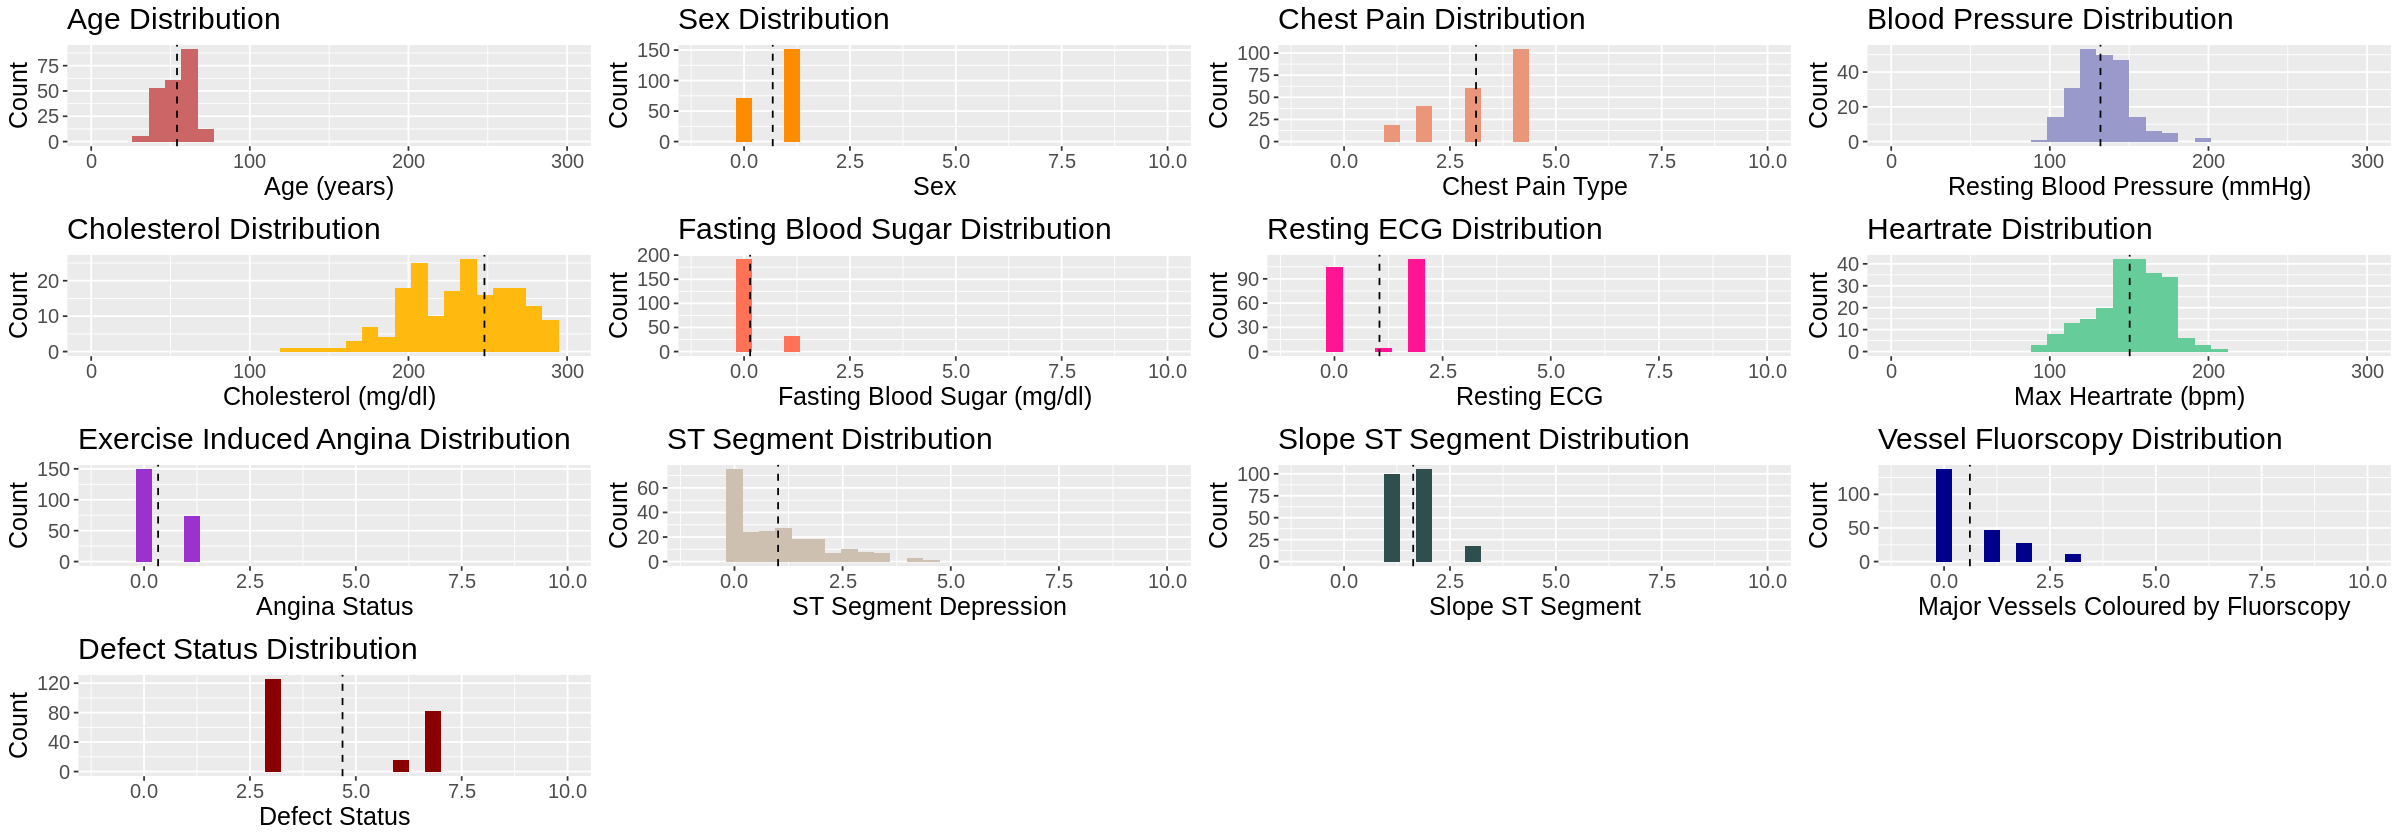

In [28]:
options(repr.plot.length = 100, repr.plot.width = 20)

predictor_means <- heart_train %>%
    select(-disease_status) %>%
    summarize(across(age:thal, mean))
predictor_means

age_hist <- heart_train %>%
    ggplot(aes(x = age)) +
    geom_histogram(fill = "#CC6666", bins=30) +
    geom_vline(xintercept = pull(predictor_means, age), linetype = "dashed", size = .5) +
    labs(x = "Age (years)", 
         y = "Count") +
    theme(text = element_text(size=15)) + 
    xlim(0, 300) +
    scale_fill_brewer(palette = "Set3") +
    ggtitle("Age Distribution")

sex_hist <- heart_train %>%
    ggplot(aes(x = sex)) +
    geom_histogram(fill = "darkorange", bins=30) +
    geom_vline(xintercept = pull(predictor_means, sex), linetype = "dashed", size = .5) +
    labs(x = "Sex", 
         y = "Count") +
    theme(text = element_text(size=15)) + 
    xlim(-1, 10) +
    scale_fill_brewer(palette = "Set3") +
    ggtitle("Sex Distribution")

cp_hist <- heart_train %>%
    ggplot(aes(x = chest_pain_type)) +
    geom_histogram(fill = "darksalmon", bins=30) +
    geom_vline(xintercept = pull(predictor_means, chest_pain_type), linetype = "dashed", size = .5) +
    labs(x = "Chest Pain Type", 
         y = "Count") +
    theme(text = element_text(size=15)) + 
    xlim(-1, 10) +
    scale_fill_brewer(palette = "Set3") +
    ggtitle("Chest Pain Distribution")

bp_hist <- heart_train %>%
    ggplot(aes(x = resting_bp)) +
    geom_histogram(fill = "#9999CC", bins=30) +
    geom_vline(xintercept = pull(predictor_means, resting_bp), linetype = "dashed", size = .5) +
    labs(x = "Resting Blood Pressure (mmHg)", 
         y = "Count") +
    theme(text = element_text(size=15)) + 
    xlim(0, 300) +
    scale_fill_brewer(palette = "Set3") +
    ggtitle("Blood Pressure Distribution")

chl_hist <- heart_train %>%
    ggplot(aes(x = cholesterol)) +
    geom_histogram(fill = "darkgoldenrod1", bins=30) +
    geom_vline(xintercept = pull(predictor_means, cholesterol), linetype = "dashed", size = .5) +
    labs(x = "Cholesterol (mg/dl)", 
         y = "Count") +
    theme(text = element_text(size=15)) + 
    xlim(0, 300) +
    scale_fill_brewer(palette = "Set3") +
    ggtitle("Cholesterol Distribution")

bs_hist <- heart_train %>%
    ggplot(aes(x = fasting_bs)) +
    geom_histogram(fill = "coral1", bins=30) +
    geom_vline(xintercept = pull(predictor_means, fasting_bs), linetype = "dashed", size = .5) +
    labs(x = "Fasting Blood Sugar (mg/dl)", 
         y = "Count") +
    theme(text = element_text(size=15)) + 
    xlim(-1, 10) +
    scale_fill_brewer(palette = "Set3") +
    ggtitle("Fasting Blood Sugar Distribution")

ecg_hist <- heart_train %>%
    ggplot(aes(x = resting_ecg)) +
    geom_histogram(fill = "deeppink", bins=30) +
    geom_vline(xintercept = pull(predictor_means, resting_ecg), linetype = "dashed", size = .5) +
    labs(x = "Resting ECG", 
         y = "Count") +
    theme(text = element_text(size=15)) + 
    xlim(-1, 10) +
    scale_fill_brewer(palette = "Set3") +
    ggtitle("Resting ECG Distribution")

hr_hist <- heart_train %>%
    ggplot(aes(x = heartrate_max)) +
    geom_histogram(fill = "#66CC99", bins=30) +
    geom_vline(xintercept = pull(predictor_means, heartrate_max), linetype = "dashed", size = .5) +
    labs(x = "Max Heartrate (bpm)", 
         y = "Count") +
    theme(text = element_text(size=15)) + 
    xlim(0, 300) +
    scale_fill_brewer(palette = "Set3") +
    ggtitle("Heartrate Distribution")

ex_hist <- heart_train %>%
    ggplot(aes(x = exang)) +
    geom_histogram(fill = "darkorchid3", bins=30) +
    geom_vline(xintercept = pull(predictor_means, exang), linetype = "dashed", size = .5) +
    labs(x = "Angina Status", 
         y = "Count") +
    theme(text = element_text(size=15)) + 
    xlim(-1, 10) +
    scale_fill_brewer(palette = "Set3") +
    ggtitle("Exercise Induced Angina Distribution")

op_hist <- heart_train %>%
    ggplot(aes(x = oldpeak)) +
    geom_histogram(fill = "antiquewhite3", bins=30) +
    geom_vline(xintercept = pull(predictor_means, oldpeak), linetype = "dashed", size = .5) +
    labs(x = "ST Segment Depression", 
         y = "Count") +
    theme(text = element_text(size=15)) + 
    xlim(-1, 10) +
    scale_fill_brewer(palette = "Set3") +
    ggtitle("ST Segment Distribution")

slope_hist <- heart_train %>%
    ggplot(aes(x = slope)) +
    geom_histogram(fill = "darkslategray", bins=30) +
    geom_vline(xintercept = pull(predictor_means, slope), linetype = "dashed", size = .5) +
    labs(x = "Slope ST Segment", 
         y = "Count") +
    theme(text = element_text(size=15)) + 
    xlim(-1, 10) +
    scale_fill_brewer(palette = "Set3") +
    ggtitle("Slope ST Segment Distribution")

ca_hist <- heart_train %>%
    ggplot(aes(x = ca)) +
    geom_histogram(fill = "darkblue", bins=30) +
    geom_vline(xintercept = pull(predictor_means, ca), linetype = "dashed", size = .5) +
    labs(x = "Major Vessels Coloured by Fluorscopy", 
         y = "Count") +
    theme(text = element_text(size=15)) + 
    xlim(-1, 10) +
    scale_fill_brewer(palette = "Set3") +
    ggtitle("Vessel Fluorscopy Distribution")

thal_hist <- heart_train %>%
    ggplot(aes(x = thal)) +
    geom_histogram(fill = "darkred", bins=30) +
    geom_vline(xintercept = pull(predictor_means, thal), linetype = "dashed", size = .5) +
    labs(x = "Defect Status", 
         y = "Count") +
    theme(text = element_text(size=15)) + 
    xlim(-1, 10) +
    scale_fill_brewer(palette = "Set3") +
    ggtitle("Defect Status Distribution")

plot_grid(age_hist,
          sex_hist,
          cp_hist,
          bp_hist,
          chl_hist,
          bs_hist,
          ecg_hist,
          hr_hist,
          ex_hist,
          op_hist,
          slope_hist,
          ca_hist,
          thal_hist, ncol = 4)

We can see from the above analysis that our predictors have very different scales and centers. Therefore, we will need to scale and center our data during our preprocessing recipe step to solve problem #2.  

The final problem we need to solve is the issue of deciding what predictors to choose. Irrelevant predictors can make our analysis less accurate. Therefore, we need to choose the best subset of predictors that will provide us with the best accuracy. To do this, we will perform a forward selection. This method is faster than if we were to use a best subset selection method, and it still provides us with fairly optimal subset of predictors.

In [29]:
pred_names <- colnames(heart_train %>% select(-disease_status))
pred_names

pred_formula <- paste("disease_status", "~", paste(pred_names, collapse="+"))
pred_formula

# create an empty tibble to store the results
accuracies <- tibble(size = integer(), 
                     model_string = character(), 
                     accuracy = numeric())

# create a model specification
knn_spec <- nearest_neighbor(weight_func = "rectangular", 
                             neighbors = tune()) %>%
     set_engine("kknn") %>%
     set_mode("classification")

# create a 5-fold cross-validation object
heart_vfold <- vfold_cv(heart_train, v = 5, strata = disease_status)

# store the total number of predictors
n_total <- length(pred_names)

# stores selected predictors
selected <- c()

# for every size from 1 to the total number of predictors
for (i in 1:n_total) {
    # for every predictor still not added yet
    accs <- list()
    models <- list()
    for (j in 1:length(names)) {
        # create a model string for this combination of predictors
        preds_new <- c(selected, pred_names[[j]])
        model_string <- paste("disease_status", "~", paste(preds_new, collapse="+"))

        # create a recipe from the model string
        heart_recipe <- recipe(as.formula(model_string), 
                                data = heart_train) %>%
                          step_scale(all_predictors()) %>%
                          step_center(all_predictors())

        # tune the KNN classifier with these predictors, 
        # and collect the accuracy for the best K
        acc <- workflow() %>%
          add_recipe(heart_recipe) %>%
          add_model(knn_spec) %>%
          tune_grid(resamples = heart_vfold, grid = 10) %>%
          collect_metrics() %>%
          filter(.metric == "accuracy") %>%
          summarize(mx = max(mean))
        acc <- acc$mx %>% unlist()

        # add this result to the dataframe
        accs[[j]] <- acc
        models[[j]] <- model_string
    }
    jstar <- which.max(unlist(accs))
    accuracies <- accuracies %>%
      add_row(size = i, 
              model_string = models[[jstar]], 
              accuracy = accs[[jstar]])
    selected <- c(selected, pred_names[[jstar]])
    pred_names <- pred_names[-jstar]
}
accuracies

[1] "age"             "sex"             "chest_pain_type" "resting_bp"     
 [5] "cholesterol"     "fasting_bs"      "resting_ecg"     "heartrate_max"  
 [9] "exang"           "oldpeak"         "slope"           "ca"             
[13] "thal"

[1] "disease_status ~ age+sex+chest_pain_type+resting_bp+cholesterol+fasting_bs+resting_ecg+heartrate_max+exang+oldpeak+slope+ca+thal"

size,model_string,accuracy
<int>,<chr>,<dbl>
1,disease_status ~ age,0.6194949
2,disease_status ~ age+sex,0.6635354
3,disease_status ~ age+sex+chest_pain_type,0.7485859
4,disease_status ~ age+sex+chest_pain_type+resting_bp,0.7574747
5,disease_status ~ age+sex+chest_pain_type+resting_bp+cholesterol,0.7263636
6,disease_status ~ age+sex+chest_pain_type+resting_bp+cholesterol+fasting_bs,0.7262626
7,disease_status ~ age+sex+chest_pain_type+resting_bp+cholesterol+fasting_bs+resting_ecg,0.7266667
8,disease_status ~ age+sex+chest_pain_type+resting_bp+cholesterol+fasting_bs+resting_ecg+heartrate_max,0.6998990
9,disease_status ~ age+sex+chest_pain_type+resting_bp+cholesterol+fasting_bs+resting_ecg+heartrate_max+exang,0.7578788


We can see from the 13th row of our forward selection results table that the subset of predictors that produces the highest accuracy is when we use all 13. In light of this we will continue with our analysis using all of our predictors. This solves the final problem of our KNN classification, and we can begin our classification analysis.  
***  

### C) Analysis Methods:  

To begin our classification analysis, we need to tune our classifier so that we know the K value that produces the most accurate classifier. To do this, we must create our model specification. This specification tells the algorithm to do a KNN classification, and that we will be tuning to establish the best parameter value. In addition, the rectangular argument dictates that each point has one vote in the classification.

In [30]:
tune_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) %>%
    set_engine("kknn") %>%
    set_mode("classification")
tune_spec

K-Nearest Neighbor Model Specification (classification)

Main Arguments:
  neighbors = tune()
  weight_func = rectangular

Computational engine: kknn 


The optimal method of tuning involves using cross-validation. Cross-validation ensures that each observation is used only once, and it allows us to get an average for each K value tested. In addition, by splitting our training data into five folds, it allows us to find the optimal K value for our classifier by validating against other subsets of training data. This way our testing data remains untainted by our training steps.

In [31]:
heart_vfold <- vfold_cv(data = heart_train, v = 5, strata = disease_status)

Now we must create a recipe that will be placed into a workflow. By using a recipe it allows us to scale and center our training data in order to solve problem #2 (that we discussed above) without the potential error of calculation by hand. In addition, we could easily add in other preprocessing steps in the future.

In [32]:
heart_recipe <- recipe(disease_status ~ . , data = heart_train) %>%
    step_scale(all_predictors()) %>%
    step_center(all_predictors())
heart_recipe

Data Recipe

Inputs:

      role #variables
   outcome          1
 predictor         13

Operations:

Scaling for all_predictors()
Centering for all_predictors()

In order to test various K values, we need to set up a tibble of all the various possible K values that we'd like our tuning process to check.

In [33]:
k_vals <- tibble(neighbors = seq(from = 1, to = 100, by = 2))
head(k_vals)
nrow(k_vals)

neighbors
<dbl>
1
3
5
7
9
11


[1] 50

Now we have all the pieces to perform our tuning and parameter value selection. We will use a workflow to combine all the work we have so far. A workflow provides a convenient an error-free way of performing our cross validation. By combining this with collect_metrics() function, we will produce an easy-to-read tibble of the various accuracies for each K value.

In [34]:
cv_heart_results <- workflow() %>%
  add_recipe(heart_recipe) %>%
  add_model(tune_spec) %>%
  tune_grid(resamples = heart_vfold, grid = k_vals) %>%
  collect_metrics() 

In [35]:
accuracies <- cv_heart_results %>%
    filter(.metric == "accuracy") %>%
    arrange(desc(mean))

head(accuracies)

neighbors,.metric,.estimator,mean,n,std_err,.config
<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
25,accuracy,binary,0.8296970,5,0.01643581,Model13
33,accuracy,binary,0.8254545,5,0.03060398,Model17
29,accuracy,binary,0.8253535,5,0.01876750,Model15
45,accuracy,binary,0.8253535,5,0.02123640,Model23
31,accuracy,binary,0.8210101,5,0.02167285,Model16
37,accuracy,binary,0.8209091,5,0.02492597,Model19


Now we can see that the K value with the highest accuracy is 25, but we also want a K value that still returns a high accuracy if the value shifts slightly. To determine the best K value we will plot this data frame so that we can easily visualize the best options.

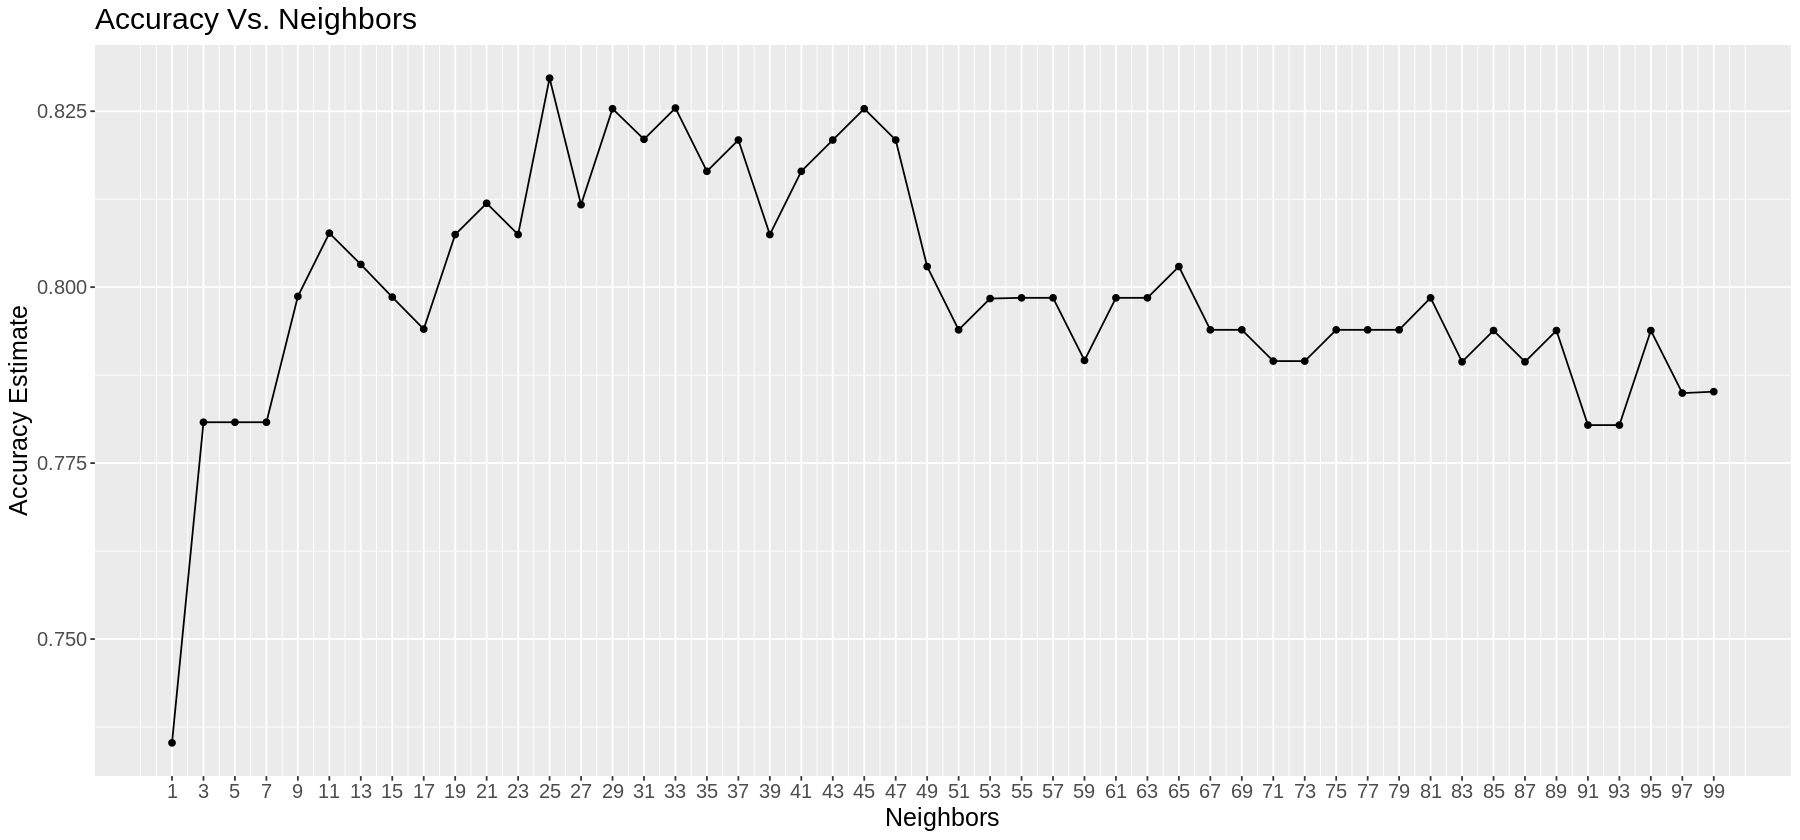

In [36]:
options(repr.plot.length = 10, repr.plot.width = 15)

accuracy_vs_k <- ggplot(accuracies, aes(x = neighbors, y = mean)) +
  geom_point() +
  geom_line() +
  labs(x = "Neighbors", y = "Accuracy Estimate") + 
  theme(text = element_text(size = 15)) +
    scale_x_continuous(breaks = seq(from = 1,to = 100,by = 2)) +
    ggtitle("Accuracy Vs. Neighbors")

accuracy_vs_k

From the above graph, it appears that any K value between 25 and 45 gives us a high accuracy. However, we will choose K=31 as our optimal parameter value because:  
1) It is not too high of a value, so computation won't be exceedingly long.  
2) It returns one of the highest accuracies.  
3) It is relatively stable on either side if the K value is changed slightly.  

Now that we have our optimal parameter, we must re-train our classifier with this parameter. To do this, we must create a new model specification that specifies our newfound optimal parameter for the neighbors argument. Next, we must use the fit function in our workflow with the entire training dataset to produce our classifier.

In [37]:
heart_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = 31) %>%
    set_engine("kknn") %>%
    set_mode("classification")
heart_spec

heart_fit <- workflow() %>%
    add_recipe(heart_recipe) %>%
    add_model(heart_spec) %>%
    fit(heart_train)
heart_fit

K-Nearest Neighbor Model Specification (classification)

Main Arguments:
  neighbors = 31
  weight_func = rectangular

Computational engine: kknn 


══ Workflow [trained] ══════════════════════════════════════════════════════════
Preprocessor: Recipe
Model: nearest_neighbor()

── Preprocessor ────────────────────────────────────────────────────────────────
2 Recipe Steps

● step_scale()
● step_center()

── Model ───────────────────────────────────────────────────────────────────────

Call:
kknn::train.kknn(formula = ..y ~ ., data = data, ks = ~31, kernel = ~"rectangular")

Type of response variable: nominal
Minimal misclassification: 0.1973094
Best kernel: rectangular
Best k: 31

Now we can predict the classes of our testing data by using our training classifier. We do this by using the predict function. Once we have these class predictions, we must bind the predictions to the original testing data. This will allow us to calculate the accuracy of our classifier with the metrics function.

In [38]:
prediction <- predict(heart_fit, heart_test) %>%
    bind_cols(heart_test) %>%
    metrics(truth = disease_status, estimate = .pred_class) %>%
    filter(.metric == "accuracy")
prediction

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.9054054


We have found the accuracy of our classifier to be approximately 90.54%!  
***

### D) Discussion:  

Over the course of this analysis we found that:  
1) Our predictor forward selection showed that the combination of all 13 possible predictors returned the highest accuracy.  
2) Using cross-validation we tuned our parameter value and found a K value of 31 provides the most accuracy and stability while tuning.  
3) We fit our training data with the KNN algorithm and the optimal K value to produce our classifier.  
4) When we predicted classes of our testing data, we found our classifier to be approximately 90.54% accurate at predicting heart disease.  

We found these results to be very interesting. Firstly, we did not expect to have so many predictors that increased the accuracy of our classifier during our forward selection. K-nn classification has a weakness of potentially not working well with many predictors. Therefore, it will punish the use of irrelevant predictors. This suggests that all available predictors provide some meaningful increase in accuracy. In addition, we were pleasantly surprised with the accuracy of our classifier on the testing data. Since the majority classifier is approximately 54%, the use of our classifier provides a significant improvement.  

Unfortunately, we do not think that the accuracy of our model is robust enough to cause significant changes/ impacts to how hospitals treat new admissions with chest pain. Even though this classifier is better than the majority classifier, the penalty for an incorrect diagnosis could be disastrous to a patient with heart disease. However, depending on how this tool is used, it could offer physicians a hint about a new patient's possible prognosis and allow them the ability to modify their treatments accordingly.  

We believe that the potential of our classifier will spark the interest for future studies. Currently, researchers testing various predictive models to answer the exact question we have asked here. There are even neural networks that are up to 95% accurate with similar heart datasets from Cleveland (Hassan et al., 2020). While our predictors are not this accurate, perhaps our work can help guide future studies with different subsets of predictors. Our hope is that this work will improve the outcomes of patients struggling with heart disease.  
***

### E) Appendix


#### References:

1) Ornish, D., Brown, B.E., Billings, J.H., Scherwitz, L.W., Armstrong, W.T., Ports, T.A., McLanahan, S.M., Kirkeeide, R.L, Gould, K.l. & Brand, R.J. (1990). Can lifestyle changes reverse coronary heart disease?: The Lifestyle Heart Trial. _The Lancet, 336_(8708), 129-133. https://doi.org/10.1016/0140-6736(90)91656-U.  
  
2) Hassan, M.I., Osman, A.H. & Hussein, E.M. (2020). Heart disease diagnosis using diverse neural network categories. _Emerging Trends in Intelligent Computing and Informatics. IRICT 2019: Advances in Intelligent Systems and Computing, 1073_(1), 373-385. https://doi.org/10.1007/978-3-030-33582-3

3) UCI Machine Learning Repository (1988). _Heart Disease Data Set_. Retrieved from: https://archive.ics.uci.edu/ml/datasets/Heart+Disease  
#### Complete attribute documentation:

* X1 age: age in years
* X2 sex: sex (1 = male; 0 = female)
* X3 chest_pain_type:
-- Value 1: typical angina
-- Value 2: atypical angina
-- Value 3: non-anginal pain
-- Value 4: asymptomatic
* X4 resting_bp: resting blood pressure (in mm Hg on admission to the hospital)
* X5 cholesterol: serum cholesterol in mg/dl
* X6 fasting_bs: (fasting blood sugar > 120 mg/dl) (1 = true; 0 = false)
* X7 resting_ecg: resting electrocardiographic results
-- Value 0: normal
-- Value 1: having ST-T wave abnormality (T wave inversions and/or ST elevation or depression of > 0.05 mV)
-- Value 2: showing probable or definite left ventricular hypertrophy by Estes' criteria
* X8 heartrate_max: maximum heart rate achieved
* X9 exang: exercise induced angina (1 = yes; 0 = no)
* X10 oldpeak = ST depression induced by exercise relative to rest
* X11 slope: the slope of the peak exercise ST segment
-- Value 1: upsloping
-- Value 2: flat
-- Value 3: downsloping
* X12 ca: number of major vessels (0-3) colored by flourosopy
* X13 thal: 3 = normal; 6 = fixed defect; 7 = reversable defect
* X14 disease_status: diagnosis of heart disease (angiographic disease status)
-- Value 0: < 50% diameter narrowing
-- Value 1: > 50% diameter narrowing